<p style="font-size:300%; background-color:pink; color:blue; text-align:center;line-height : 80px; margin : 0; padding : 0;">
Taller 8: Sistemas difusos en visión de máquina</p>
<p style="font-size:240%; background-color:pink; color:red; text-align:center;line-height : 60px; margin : 0; padding : 0;">
    
Técnicas de Inteligencia Artificial - Visión de Máquina </p1>

<p style="font-size:200%; text-align:center; line-height : 40px;  margin-top : 0; margin-bottom : 0; "> 
  <br>Est. Brian Camilo Valencia Peña (bcvalenciap@unal.edu.co)
  <br>Est. Esteban Ladino Fajardo (eladinof@unal.edu.co)
</p>

<p style="font-size:180%; text-align:center; line-height : 30px;  margin-top : 0; margin-bottom : 0; "> <br><br>INGENIERÍA ELECTRÓNICA</p>
<p style="font-size:180%; text-align:center; line-height : 30px; margin-top : 0; "> Facultad de Ingeniería</p>
<p style="font-size:160%; text-align:center; line-height : 30px; margin-top : 0; "> Universidad Nacional de Colombia Sede Bogotá</p>
<br>
<img src="figs/Escudo_UN.png",width=100,height=100>

<p style="font-size:160%; text-align:center; line-height : 30px; margin-top : 0; "> <br>20 de Junio de 2022</p>

## Enunciado

1. Estudiar las funciones en API Reference, de la biblioteca
Scikit-Fuzzy. http://pythonhosted.org/scikit-fuzzy/api/api.html


2.  Estudiar el ejemplo: Fuzzy Control Systems: The Tipping Problem, en la misma biblioteca.





Source code for skfuzzy.filters.fire
fire2d
2-D filtering using Fuzzy Inference Ruled by Else-action (FIRE)

FIRE filtering is nonlinear, and is specifically designed to remove impulse (salt and pepper) noise.

http://pythonhosted.org/scikit-fuzzy/api/skfuzzy.filters.html

Fabrizio Russo, Fuzzy Filtering of Noisy Sensor Data, IEEE Instrumentation and Measurement Technology Conference, Brussels, Belgium, June 4 - 6, 1996, pp 1281 - 1285.

Función
* http://pythonhosted.org/scikit-fuzzy/_modules/skfuzzy/filters/fire.html


In [1]:
##Parametros
#  I : vector 2d  * imagen de entrada.
#  l2 : float limite maximo de rango de filtrado
#  fuzzyresolution : float, default = 1
##Returns:
# J : vector2d  * imagen filtrada
# ##NOTA
# El filtrado ocurre cuando  l1<|x|<l2 ; fuera de este rango no se aplica.

from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

import cv2
%matplotlib inline

import os

def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.004
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * gauss
        return noisy



Funcion noisy
La función agrega ruido gaussiano, salpimienta, poisson y moteado en una imagen. Esto se hace con el obj de aplicarle posteriormente los filtros de logica difusa a la imagen y limpiarla.

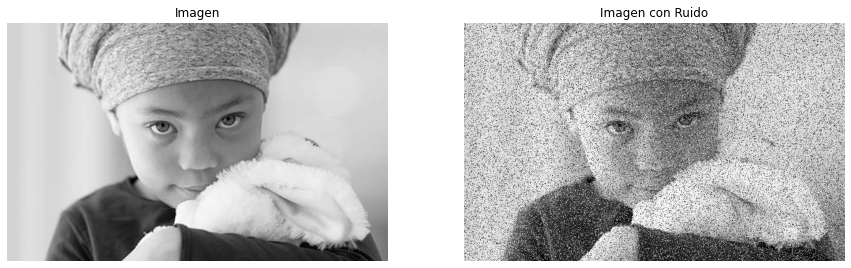

In [3]:
def sp_noise(image, prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = image.copy()
    if len(image.shape) == 2:
        black = 0
        white = 255            
    else:
        colorspace = image.shape[2]
        if colorspace == 3:  # RGB
            black = np.array([0, 0, 0], dtype='uint8')
            white = np.array([255, 255, 255], dtype='uint8')
        else:  # RGBA
            black = np.array([0, 0, 0, 255], dtype='uint8')
            white = np.array([255, 255, 255, 255], dtype='uint8')
    probs = np.random.random(output.shape[:2])
    output[probs < (prob / 2)] = black
    output[probs > 1 - (prob / 2)] = white
    return output

img = cv2.imread('figs/imag.jpg',1)
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#
noise_img = sp_noise(img1,0.2)
#noise_img = noisy("s&p",img)
#img2 = cv2.cvtColor(noise_img, cv2.COLOR_BGR2GRAY)

plt.figure(1,figsize=(15,15))
plt.subplot(221), plt.imshow(img1, cmap='gray'), plt.title('Imagen'), plt.axis("off")
plt.subplot(222), plt.imshow(noise_img, cmap='gray'), plt.title('Imagen con Ruido'), plt.axis("off")
plt.show()



Text(0.5, 1.0, 'Test data: 200 points x3 clusters.')

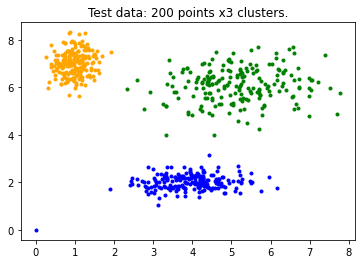

In [4]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

%matplotlib inline



colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Define los centros de los cluster 
centers = [[4, 2],
           [1, 7],
           [5, 6]]

# Define los cluster sigmas en x e y, respectivamente
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

# Genera información de prueba
np.random.seed(42)  # Establecer semilla para la reproducibilidad
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(200) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(200) * i))

# Visualizar los datos de prueba
fig0, ax0 = plt.subplots()
for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
ax0.set_title('Test data: 200 points x3 clusters.')

## Clustering

Arriba están los datos de prueba.
    * Se ven tres manchas distintas.
    * ¿Quizás si los datos no estan tan claramente agrupados?

* A continuación se intenta agrupar los datos varias veces, con entre 2 y 9 grupos.

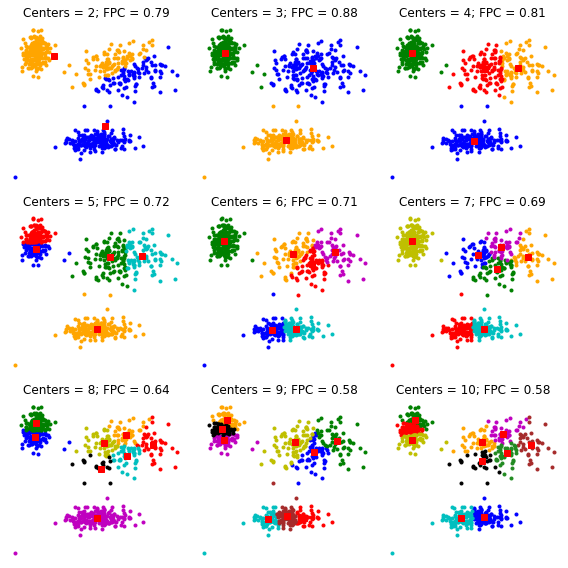

In [5]:
# Configurar el bucle y trazar
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Almacenar valores fpc para más tarde
    fpcs.append(fpc)

    # Trazar grupos asignados, para cada punto de datos en el conjunto de entrenamiento
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Marcar el centro de cada grupo borroso
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

## El coeficiente de partición difusa (FPC)
Se define en el rango de 0 a 1, siendo 1 el mejor. Es una métrica que indica cuán limpiamente los datos son descritos por un determinado modelo. Luego se muestran los resultados de la agrupación y se traza el coeficiente de partición difusa. Cuando se maximiza el FPC, los datos se describen mejor. 

Tener el FPC disponible puede ser muy útil cuando la estructura de sus datos no está clara. Tenga en cuenta que se comenzó con dos centros, no uno; agrupar un conjunto de datos con un solo centro de clúster es la solución trivial y, por definición, devolverá FPC == 1.


3. Implementar alguno de los siguientes algoritmos que emplean lógica difusa (vistos en clase), como una función de phyton:


    3.1 Detector de bordes difuso3 .

    3.2 Segmentación difusa por umbralización4 .

Text(0, 0.5, 'Fuzzy partition coefficient')

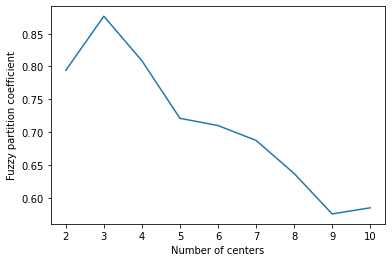

In [6]:
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

## Modelo
* Sabemos que nuestro mejor modelo tiene tres centros de conglomerados.
* Reconstruiremos un modelo de 3 grupos para usarlo en la predicción, generar nuevos datos uniformes y predecir a qué grupo pertenece cada nuevo punto de datos.

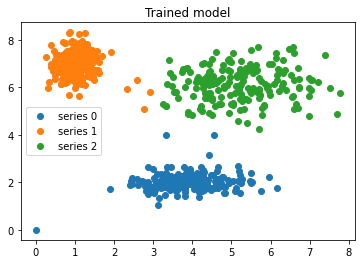

In [7]:
# Regenerar el modelo borroso con 3 centros de conglomerados: tenga en cuenta que el orden de los centros
# es aleatorio en este algoritmo de agrupación, por lo que los centros pueden cambiar de lugar
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
    alldata, 3, 2, error=0.005, maxiter=1000)

# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(3):
    ax2.plot(alldata[0, u_orig.argmax(axis=0) == j],
             alldata[1, u_orig.argmax(axis=0) == j], 'o',
             label='series ' + str(j))
ax2.legend()

# Predicción
* Finalmente, generamos datos muestreados uniformemente sobre este campo y los clasificamos a través de cmeans_predict, incorporándolos al modelo preexistente.

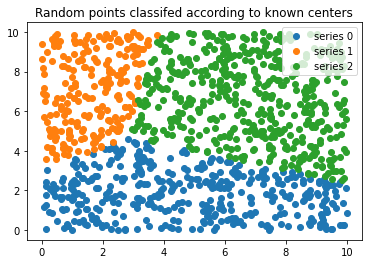

In [8]:
# Genere datos muestreados uniformemente distribuidos en el rango [0, 10] en x e y
newdata = np.random.uniform(0, 1, (1100, 2)) * 10

# Predecir nuevos miembros del clúster con `cmeans_predict` así como
# `cntr`del modelo de 3 clústeres
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    newdata.T, cntr, 2, error=0.005, maxiter=1000)

# Trazar los datos uniformes clasificados. Tenga en cuenta para la visualización el máximo
# valor de membresía se ha tomado en cada punto (es decir, estos se endurecen,
# no se visualizan resultados borrosos) pero el resultado borroso completo es la salida
# from cmeans_predict.
cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization

fig3, ax3 = plt.subplots()
ax3.set_title('Random points classifed according to known centers')
for j in range(3):
    ax3.plot(newdata[cluster_membership == j, 0],
             newdata[cluster_membership == j, 1], 'o',
             label='series ' + str(j))
ax3.legend()

plt.show()

## 3. Implementar alguno de los siguientes algoritmos 
que emplean lógica difusa (vistos en clase), como una función
de phyton:

▶ Detector de bordes difuso3.

▶ Segmentación difusa por umbralización4

In [2]:
# Librerías tercer punto
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Desarrollo Detector de bordes difuso3 [1], [2]

Las funciones de las variables lingüisticas Black y White, se muestra a continuación:


![figs/FuncionesDeRelacion.png](figs/FuncionesDeRelacion.png)

*Funciones de pertenencia del conjunto difuso.[1,Pág. 180]*

Al suponer que la abscisa sea *x* y la ordenada *y* se tiene la siguiente Ecuación para la parte donde la pendiente es distinta de cero:

$$
y(x)= \frac{y_2-y_1}{x_2-x_1} (x-x_1)+y_1
$$

Así, las función para el Negro es:

$$
B(b)=
\left\{
\begin{array}{ll}
1 & \;; 0 \leq b \leq b_1  \\
\frac{B_2-B_1}{b_2-b_1} (b-b_1)+B_1 & \;; b_1 < b < b_2  \\
0 & \;; b_2 \leq b \leq 255  \\  
\end{array}
\right. 
$$

Donde, 

* B: Asignación difusa del negro.
* b: Escala de gris.

Para el blanco se tiene la siguiente función:
$$
W(w)=
\left\{
\begin{array}{ll}
1 & \;; 0 \leq b \leq b_1  \\
\frac{W_2-W_1}{w_2-w_1} (w-w_1)+W_1 & \;; w_1 < w < w_2  \\
0 & \;; w_2 \leq w \leq 255  \\  
\end{array}
\right. 
$$

Donde, 

* W: Asignación difusa del blanco.
* b: Escala de gris.

Al implementarse en python, se tiene:

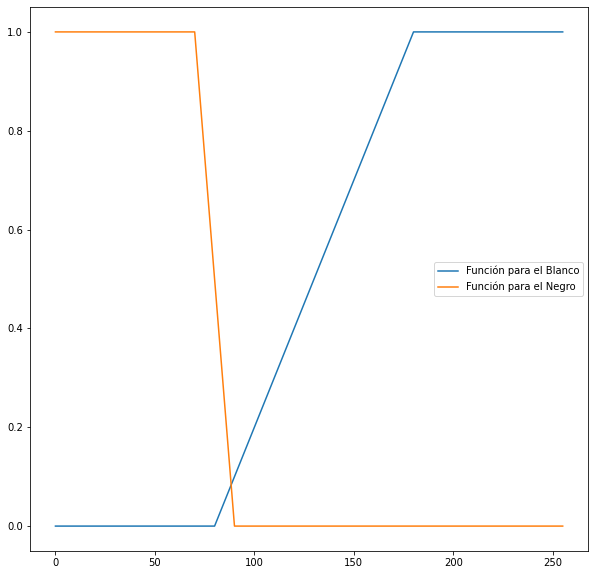

In [3]:
def fun_negro(b,B1,b1,B2,b2):

    if b2<=b<=255:
        return 0
    elif b1<b<b2:
        return (float)(B2-B1)*(b-b1)/(b2-b1)+B1
    else:
        return 1

def fun_blanco(w,W1,w1,W2,w2):
    if w2<=w<=255:
        return 1
    elif w1<w<w2:
        return (float)(W2-W1)*(w-w1)/(w2-w1)+W1
    else:
        return 0

# Asignación del negro    
b=np.arange(0,256,1)
B=np.zeros(b.shape,dtype=float)
B1=1
b1=70
B2=0
b2=90


for i in b:
    B[i]=fun_negro(i,B1,b1,B2,b2)

# Asignación del blanco    
w=np.arange(0,256,1)
W=np.zeros(b.shape,dtype=float)
W1=0
w1=80
W2=1
w2=180


for i in w:
    W[i]=fun_blanco(i,W1,w1,W2,w2)
    
plt.figure(figsize=(10, 10))  
plt.plot(w,W,label='Función para el Blanco')
plt.plot(b,B,label='Función para el Negro')
plt.legend()
plt.show()

Las funciones anteriores sirven para la fusificación, para la defusificación del borde se usará la gráfica rojo de la siguiente Figura.

![figs/Defusificacion.png](figs/Defusificacion.png)

Para que la función sea sobreyectiva (Teniendo en cuenta la defusificación) se va a definir de la siguiente forma para la identificación del borde.

Para el blanco se tiene la siguiente función:
$$
e(E)=135 \; ; E \neq 0 
$$

La función anterior implica que se le va a asignar el valor de 135 al pixel que al aplicar las reglas del sistema difuso de distinto de cero. En python se implementa así:

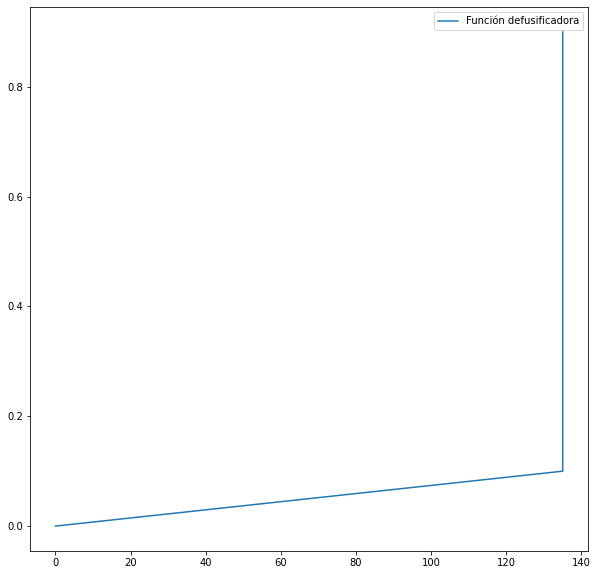

In [4]:
def funBordes(E):
    if E==0:
        return 0
    return 135

E=np.arange(0,1,0.1)
e=np.zeros(E.shape,dtype=int)
for i in range(len(E)):
    e[i]=funBordes(E[i])

plt.figure(figsize=(10, 10))  
plt.plot(e,E,label='Función defusificadora')
plt.legend()
plt.show()


Las reglas del sistema difuso que proponen Abdallah A. Alshennawy, y Ayman A. Aly son:

![figs/Reglas1-4.png](figs/Reglas1-4.png)
*Reglas difusas para líneas verticales y horizontales.[1, Pág. 180]*

![figs/Reglas5-8.png](figs/Reglas5-8.png)
*Reglas difusas para los bordes restantes.[1, Pág. 180]*

Se resalta que todos los bordes son detectados con estas ocho reglas, los operadores AND y OR se sustituyen por las funciones mínimo y máximo respectivamente. Los pasos que se realizan para hallar los contornos de se muestra a continuación:

![figs/Reglas5-8.png](figs/PasosParaHallarBordes.png)
*Pasos para hallar los bordes.[1, Pág. 181]*

Al pixel (i,j) se le realiza la fusificación y se obtiene un sistema inferencial difuso. Luego, al aplicar la defusificación mediante las reglas difusas se determina si es blanco, negro o es un borde. En este caso solo se detecta el borde. 




In [5]:
# Aplicación de reglas difusas

def reglasDifusas(EBlancos,ENegros):
    
    E_1B,E_2B,E_3B,E_4B,E_5B,E_6B,E_7B,E_8B,E_9B=EBlancos
    E_1N,E_2N,E_3N,E_4N,E_5N,E_6N,E_7N,E_8N,E_9N=ENegros

    # regla 1
    ra=min(E_1B,min(E_2B,E_3B))
    rb=min(E_4B,min(E_5B,E_6B))
    rc=min(E_7N,min(E_8N,E_9N))

    r1=min(ra,min(rb,rc))

    # Regla 2
    ra=min(E_1N,min(E_2N,E_3N))
    rb=min(E_4B,min(E_5B,E_6B))
    rc=min(E_7B,min(E_8B,E_9B))

    r2=min(ra,min(rb,rc))

    # Regla 3
    ra=np.amin([
    E_2B,E_3B,
    E_5B,E_6B,
    E_8B,E_9B
    ])

    rb=np.min([E_1N,
    E_4N,
    E_7N
    ])

    r3=min(ra,rb)
    
    # Regla 4
    ra=np.amin([E_1B,E_2B,
    E_4B,E_5B,
    E_7B,E_8B
    ])

    rb=np.min([E_3N,
    E_6N,
    E_9N
    ])

    r4=min(ra,rb)
    
    # Regla 5
    ra=np.amin([E_1N,E_2N,E_4N,E_7N])
    rb=np.amin([E_3B,E_5B,E_6B,E_8B,E_9B])
   
    r5=min(ra,rb)

    # Regla 6
    ra=np.amin([E_1B,E_2B,E_4B,E_7B,E_5B])
    rb=np.amin([E_3N,E_6N,E_8N,E_9N])
   
    r6=min(ra,rb)

    # Regla 7
    
    ra=np.amin([E_1N,E_4N,E_7N,E_8N])
    rb=np.amin([E_2B,E_3B,E_5B,E_6B,E_9B])
   
    r7=min(ra,rb)

    # Regla 8
    ra=np.amin([E_1B,E_4B,E_7B,E_5B,E_8B])
    rb=np.amin([E_2N,E_3N,E_6N,E_9N])
   
    r8=min(ra,rb)

    return np.amax([r1,r2,r3,r4,r5,r6,r7,r8])

def funFusificacion(img_gray):
    '''  
    img_gray: Imagen en escala de grises
    '''
    # Asignación del negro    
    B1=1
    b1=70
    B2=0
    b2=90


    # Asignación del blanco    
    W1=0
    w1=80
    W2=1
    w2=180

  
   

    n,m=img_gray.shape
    img_negro=np.zeros([n,m],dtype=np.uint8)
    img_blanco=np.zeros([n,m],dtype=np.uint8)

    for i in range(n):
        for j in range(m):
            img_negro[i,j]=fun_negro(img_gray[i,j],B1,b1,B2,b2)
            img_blanco[i,j]=fun_blanco(img_gray[i,j],W1,w1,W2,w2)
            

    return [img_blanco,img_negro]

def funDeFusificacion(img_blanco,img_negro):
    n,m=img_blanco.shape
    auxImgContorno=np.zeros([n,m],dtype=np.uint8)

    # Se aplican las reglas difusas
    for i in range(1,n-1,1):
        for j in range(1,m-1,1):

            arrayNegros=np.array([img_negro[i-1,j-1],img_negro[i-1,j],img_negro[i-1,j+1],
                img_negro[i,j-1],img_negro[i,j],img_negro[i,j+1],
                img_negro[i+1,j-1],img_negro[i+1,j],img_negro[i+1,j+1]])

            arrayBlancos=np.array([img_blanco[i-1,j-1],img_blanco[i-1,j],img_blanco[i-1,j+1],
                img_blanco[i,j-1],img_blanco[i,j],img_blanco[i,j+1],
                img_blanco[i+1,j-1],img_blanco[i+1,j],img_blanco[i+1,j+1]])

            auxImgContorno[i,j]=reglasDifusas(arrayNegros,arrayBlancos)

    return auxImgContorno

def funDetectorBordesDifuso(auxImgContorno):
    
    n,m=auxImgContorno.shape
    bordes=np.zeros([n,m],dtype=np.uint8)

    for i in range(n):
        for j in range(m):
            bordes[i,j]=funBordes(auxImgContorno[i,j])
            if bordes[i,j]!=0:
                bordes[i,j]=255
    
    return bordes


Ahora, se ponen a prueba las funciones realizadas

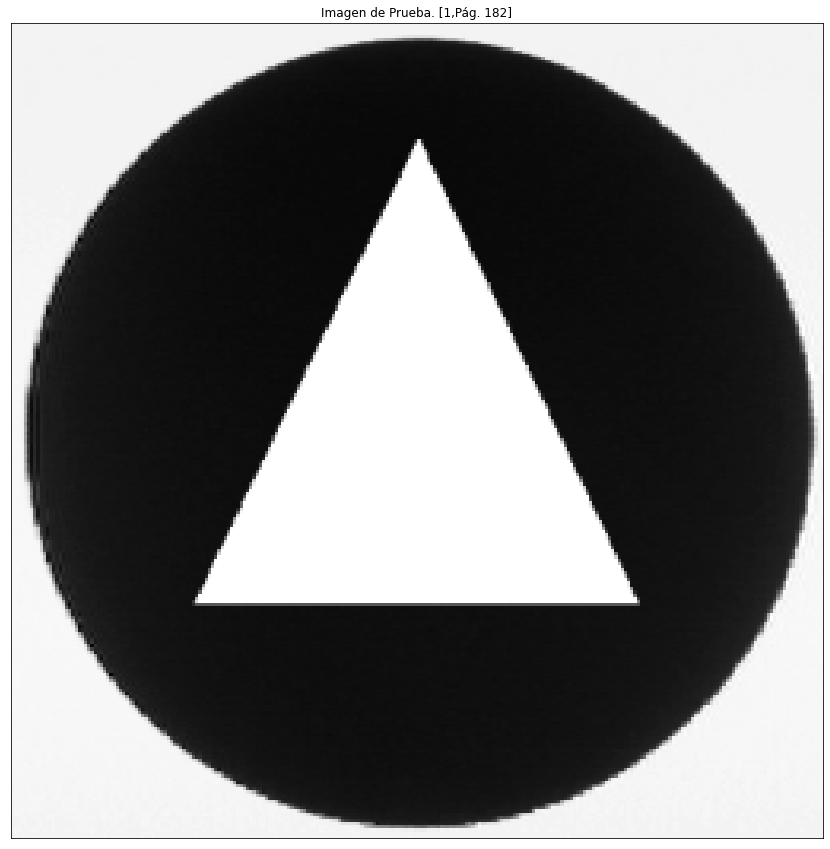

In [6]:
imagen=cv2.imread(f'figs/imagenTest.png')
imagen=cv2.cvtColor(imagen,cv2.COLOR_BGR2RGB)
imagen_gray=cv2.cvtColor(imagen,cv2.COLOR_RGB2GRAY)

n=imagen_gray.shape[0]
m=imagen_gray.shape[1]

escala= 256/min(n,m)

imagen_gray= cv2.resize(imagen_gray, None, fx=escala, fy= escala,\
                                interpolation= cv2.INTER_LINEAR)

plt.figure(figsize=(15, 15))

plt.subplot(1,1,1),plt.imshow(imagen_gray,cmap = 'gray')
plt.title('Imagen de Prueba. [1,Pág. 182]')
plt.xticks([]),plt.yticks([])

plt.show()

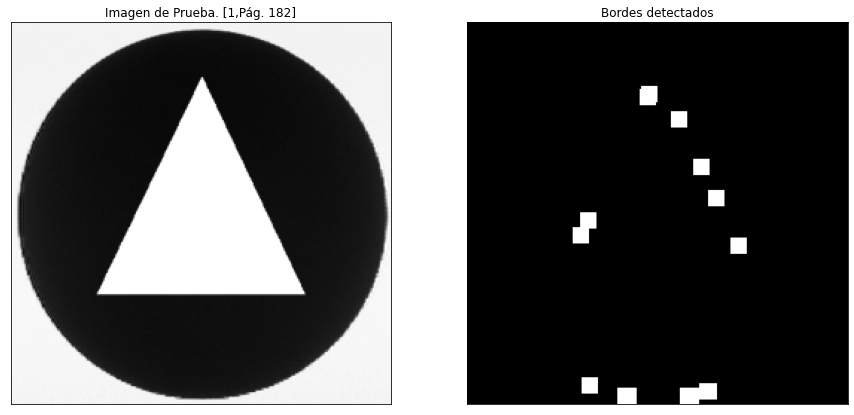

In [7]:
img_blanco,img_negro=funFusificacion(imagen_gray)
auxImgContorno=funDeFusificacion(img_blanco,img_negro)
img_bordes_difusos=funDetectorBordesDifuso(auxImgContorno)

elemento_rectangular = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
kernel=elemento_rectangular

img_bordes_difusos=cv2.dilate(img_bordes_difusos,kernel,iterations = 5)

plt.figure(figsize=(15, 15))

plt.subplot(1,2,1),plt.imshow(imagen_gray,cmap = 'gray')
plt.title('Imagen de Prueba. [1,Pág. 182]')
plt.xticks([]),plt.yticks([])


plt.subplot(1,2,2),plt.imshow(img_bordes_difusos,cmap = 'gray')
plt.title('Bordes detectados')
plt.xticks([]),plt.yticks([])

plt.show()


### Función para la detección de bordes mediante lógica difusa

Dado que el detector de bordes funcionó (no tan óptimamente) se procede a realizar la función

In [8]:
def detectorDeBordesDifuso(imagen_gray,B,b,W,w):
    # Aplicación de reglas difusas

    def reglasDifusas(EBlancos,ENegros):
        
        E_1B,E_2B,E_3B,E_4B,E_5B,E_6B,E_7B,E_8B,E_9B=EBlancos
        E_1N,E_2N,E_3N,E_4N,E_5N,E_6N,E_7N,E_8N,E_9N=ENegros

        # regla 1
        ra=min(E_1B,min(E_2B,E_3B))
        rb=min(E_4B,min(E_5B,E_6B))
        rc=min(E_7N,min(E_8N,E_9N))

        r1=min(ra,min(rb,rc))

        # Regla 2
        ra=min(E_1N,min(E_2N,E_3N))
        rb=min(E_4B,min(E_5B,E_6B))
        rc=min(E_7B,min(E_8B,E_9B))

        r2=min(ra,min(rb,rc))

        # Regla 3
        ra=np.amin([
        E_2B,E_3B,
        E_5B,E_6B,
        E_8B,E_9B
        ])

        rb=np.min([E_1N,
        E_4N,
        E_7N
        ])

        r3=min(ra,rb)
        
        # Regla 4
        ra=np.amin([E_1B,E_2B,
        E_4B,E_5B,
        E_7B,E_8B
        ])

        rb=np.min([E_3N,
        E_6N,
        E_9N
        ])

        r4=min(ra,rb)
        
        # Regla 5
        ra=np.amin([E_1N,E_2N,E_4N,E_7N])
        rb=np.amin([E_3B,E_5B,E_6B,E_8B,E_9B])
    
        r5=min(ra,rb)

        # Regla 6
        ra=np.amin([E_1B,E_2B,E_4B,E_7B,E_5B])
        rb=np.amin([E_3N,E_6N,E_8N,E_9N])
    
        r6=min(ra,rb)

        # Regla 7
        
        ra=np.amin([E_1N,E_4N,E_7N,E_8N])
        rb=np.amin([E_2B,E_3B,E_5B,E_6B,E_9B])
    
        r7=min(ra,rb)

        # Regla 8
        ra=np.amin([E_1B,E_4B,E_7B,E_5B,E_8B])
        rb=np.amin([E_2N,E_3N,E_6N,E_9N])
    
        r8=min(ra,rb)

        return np.amax([r1,r2,r3,r4,r5,r6,r7,r8])
    
    def fun_negro(b,B1,b1,B2,b2):

        if b2<=b<=255:
            return 0
        elif b1<b<b2:
            return (float)(B2-B1)*(b-b1)/(b2-b1)+B1
        else:
            return 1

    def fun_blanco(w,W1,w1,W2,w2):
        if w2<=w<=255:
            return 1
        elif w1<w<w2:
            return (float)(W2-W1)*(w-w1)/(w2-w1)+W1
        else:
            return 0
    def funBordes(E):
        if E==0:
            return 0
        return 135
        
    def funFusificacion(img_gray):
        '''  
        img_gray: Imagen en escala de grises
        '''
        # Asignación del negro    
        B1,B2=B
        b1,b2=b

        # Asignación del blanco    

        W1,W2=W
        w1,w2=w

        # Se grafican las funciones difusas para el negro y el blanco
        # Asignación del negro    
        auxb=np.arange(0,256,1)
        auxB=np.zeros(auxb.shape,dtype=float)


        for i in auxb:
            auxB[i]=fun_negro(i,B1,b1,B2,b2)

        # Asignación del blanco    
        auxw=np.arange(0,256,1)
        auxW=np.zeros(auxw.shape,dtype=float)


        for i in auxw:
            auxW[i]=fun_blanco(i,W1,w1,W2,w2)
            
        plt.figure(figsize=(10, 10))  
        plt.plot(auxw,auxW,label='Función para el Blanco')
        plt.plot(auxb,auxB,label='Función para el Negro')
        plt.legend()
        plt.show()
        

        n,m=img_gray.shape
        img_negro=np.zeros([n,m],dtype=np.uint8)
        img_blanco=np.zeros([n,m],dtype=np.uint8)

        for i in range(n):
            for j in range(m):
                img_negro[i,j]=fun_negro(img_gray[i,j],B1,b1,B2,b2)
                img_blanco[i,j]=fun_blanco(img_gray[i,j],W1,w1,W2,w2)
                

        return [img_blanco,img_negro]

    def funDeFusificacion(img_blanco,img_negro):
        n,m=img_blanco.shape
        auxImgContorno=np.zeros([n,m],dtype=np.uint8)

        # Se aplican las reglas difusas a cada pixel i,j
        for i in range(1,n-1,1):
            for j in range(1,m-1,1):

                arrayNegros=np.array([img_negro[i-1,j-1],img_negro[i-1,j],img_negro[i-1,j+1],
                    img_negro[i,j-1],img_negro[i,j],img_negro[i,j+1],
                    img_negro[i+1,j-1],img_negro[i+1,j],img_negro[i+1,j+1]])

                arrayBlancos=np.array([img_blanco[i-1,j-1],img_blanco[i-1,j],img_blanco[i-1,j+1],
                    img_blanco[i,j-1],img_blanco[i,j],img_blanco[i,j+1],
                    img_blanco[i+1,j-1],img_blanco[i+1,j],img_blanco[i+1,j+1]])

                auxImgContorno[i,j]=reglasDifusas(arrayNegros,arrayBlancos)

        return auxImgContorno

    def funDetectorBordesDifuso(auxImgContorno):
        
        n,m=auxImgContorno.shape
        bordes=np.zeros([n,m],dtype=np.uint8)

        for i in range(n):
            for j in range(m):
                bordes[i,j]=funBordes(auxImgContorno[i,j])
                if bordes[i,j]!=0:
                    bordes[i,j]=255
        
        return bordes
    
    img_blanco,img_negro=funFusificacion(imagen_gray)
    auxImgContorno=funDeFusificacion(img_blanco,img_negro)
    return funDetectorBordesDifuso(auxImgContorno)

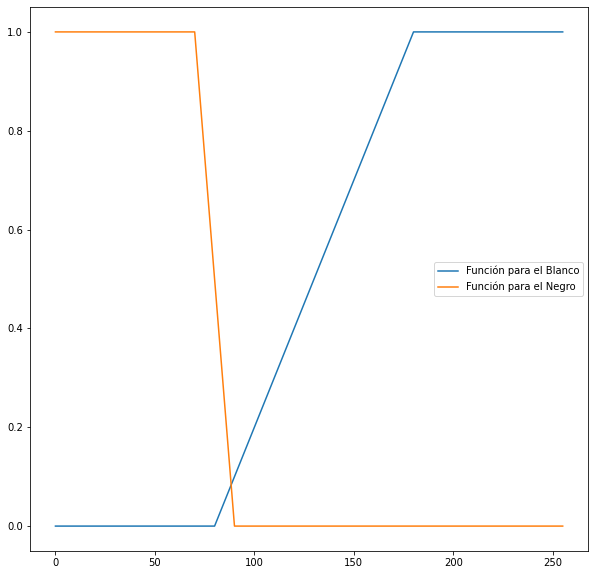

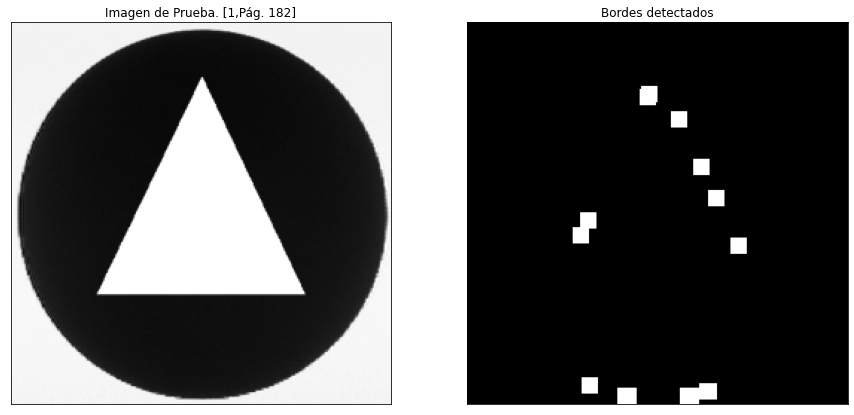

In [9]:
## Utilización de la función
# Asignación del negro    
B1=1
b1=70
B2=0
b2=90


# Asignación del blanco    
W1=0
w1=80
W2=1
w2=180

img_bordes_difusos=detectorDeBordesDifuso(imagen_gray,[B1,B2],[b1,b2],[W1,W2],[w1,w2])
img_bordes_difusos=cv2.dilate(img_bordes_difusos,kernel,iterations = 5)

plt.figure(figsize=(15, 15))

plt.subplot(1,2,1),plt.imshow(imagen_gray,cmap = 'gray')
plt.title('Imagen de Prueba. [1,Pág. 182]')
plt.xticks([]),plt.yticks([])


plt.subplot(1,2,2),plt.imshow(img_bordes_difusos,cmap = 'gray')
plt.title('Bordes detectados')
plt.xticks([]),plt.yticks([])

plt.show()

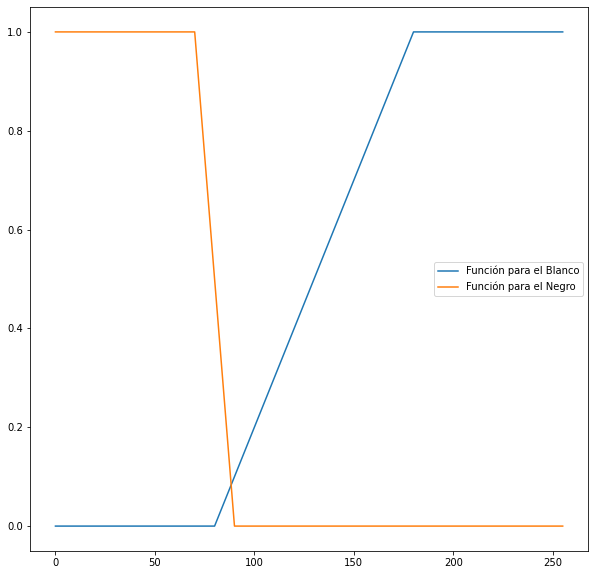

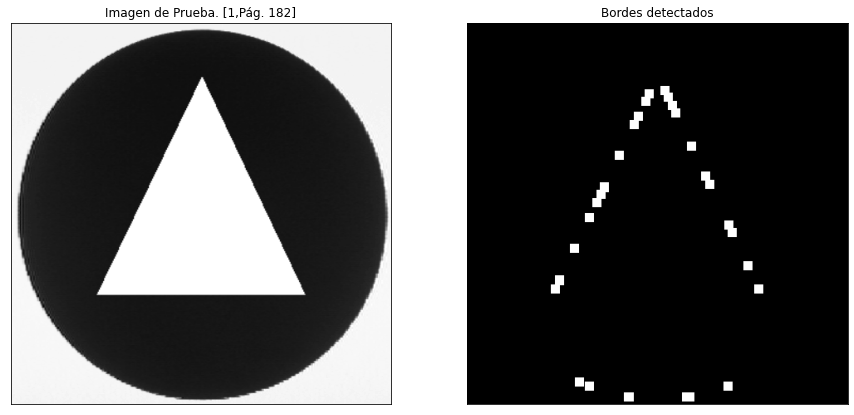

In [10]:
## Aumento de resolución

imagen_gray=cv2.cvtColor(imagen,cv2.COLOR_RGB2GRAY)

img_bordes_difusos=detectorDeBordesDifuso(imagen_gray,[B1,B2],[b1,b2],[W1,W2],[w1,w2])
img_bordes_difusos=cv2.dilate(img_bordes_difusos,kernel,iterations = 5)

plt.figure(figsize=(15, 15))

plt.subplot(1,2,1),plt.imshow(imagen_gray,cmap = 'gray')
plt.title('Imagen de Prueba. [1,Pág. 182]')
plt.xticks([]),plt.yticks([])


plt.subplot(1,2,2),plt.imshow(img_bordes_difusos,cmap = 'gray')
plt.title('Bordes detectados')
plt.xticks([]),plt.yticks([])

plt.show()

Nótese que al aumentar la resolución aumenta el la detección del contorno.

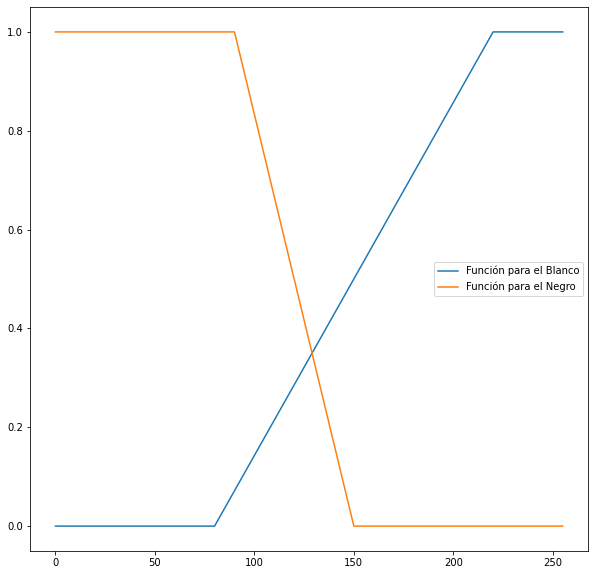

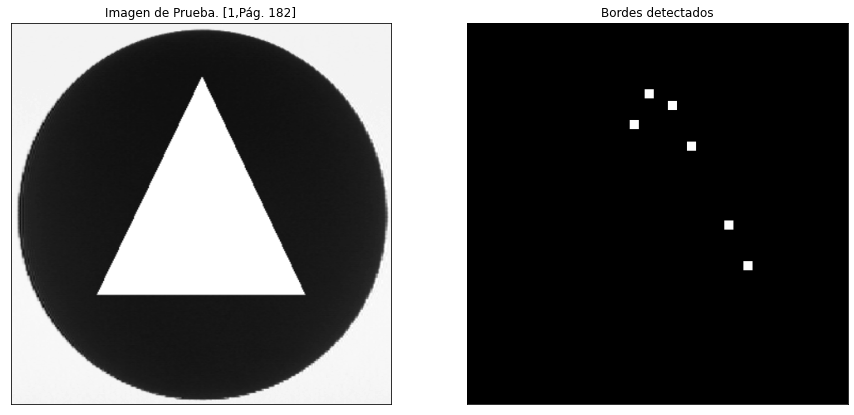

In [11]:
## Variación de la función que define el blanco y el negro
# Asignación del negro    
B1=1
b1=90
B2=0
b2=150


# Asignación del blanco    
W1=0
w1=80
W2=1
w2=220

img_bordes_difusos=detectorDeBordesDifuso(imagen_gray,[B1,B2],[b1,b2],[W1,W2],[w1,w2])
img_bordes_difusos=cv2.dilate(img_bordes_difusos,kernel,iterations = 5)

plt.figure(figsize=(15, 15))

plt.subplot(1,2,1),plt.imshow(imagen_gray,cmap = 'gray')
plt.title('Imagen de Prueba. [1,Pág. 182]')
plt.xticks([]),plt.yticks([])


plt.subplot(1,2,2),plt.imshow(img_bordes_difusos,cmap = 'gray')
plt.title('Bordes detectados')
plt.xticks([]),plt.yticks([])

plt.show()

Además, es sensible a los cambios de la función que define el blanco y el negro. 

## Referencias

[1] A. Alshennawy y A. Aly, «Edge Detection in digital images using Fuzzy logic technique», World Academy of Science, Engineering and Technology, vol. 39, mar. 2009.


[2]D. Vargas Medina, «Lógica Difusa en Visión de Máquina - Técnicas de Inteligencia Artificial: Visión de Máquina», Bogotá DC, 9 de junio de 2022.
